# Input's Normalization이 AEC 성능에 미치는 영향 확인

In [1]:
import numpy as np
import soundfile as sf

import pandas as pd
import matplotlib.pyplot as plt

### Set Algorithm

In [2]:
def float_to_short(x):
    x = x*32768.0
    x[x < -32767.5] = -32768
    x[x > 32766.5] = 32767
    x = np.floor(0.5+x)
    return x

In [3]:
class My_MDF:
    def __init__(self, fs: int, frame_size: int, filter_length: int) -> None: 
        self.sampling_rate = fs
        self.frame_size = frame_size
        self.filter_length = filter_length
        self.window_size = frame_size*2
        N = self.window_size
        self.MDF_blocks = int(np.fix((filter_length+frame_size-1)/frame_size))
        MDF_blocks = self.MDF_blocks
        
        # nb_mic = 1
        # nb_speakers = 1
        self.num_spk = 1
        num_spk = self.num_spk
        self.num_mic = 1
        num_mic = self.num_mic
        
        self.cancel_count = 0
        self.sum_adapt = 0
        self.saturated = 0
        self.screwed_up = 0

        self.spec_average = (self.frame_size)/(self.sampling_rate)
        self.beta0 = (2.0*self.frame_size)/self.sampling_rate
        self.beta_max = (.5*self.frame_size)/self.sampling_rate
        self.leak_estimate = 0        
        #-----------------------------------------------------------------------
        self.e = np.zeros((N, num_mic),)
        self.x = np.zeros((N, num_spk),)
        self.input = np.zeros((self.frame_size, num_mic),)
        self.y = np.zeros((N, num_mic),)
        self.last_y = np.zeros((N, num_mic),)
        self.Yf = np.zeros((self.frame_size+1, 1),)
        self.Rf = np.zeros((self.frame_size+1, 1),)
        self.Xf = np.zeros((self.frame_size+1, 1),)
        self.Yh = np.zeros((self.frame_size+1, 1),)
        self.Eh = np.zeros((self.frame_size+1, 1),)

        self.X = np.zeros((N, num_spk, MDF_blocks+1), dtype=complex)
        self.Y = np.zeros((N, num_mic), dtype=complex)
        self.E = np.zeros((N, num_mic), dtype=complex)
        self.W = np.zeros((N, num_spk, MDF_blocks, num_mic), dtype=complex)
        self.foreground = np.zeros((N, num_spk, MDF_blocks, num_mic), dtype=complex)
        self.PHI = np.zeros((frame_size+1, 1),)
        self.power = np.zeros((frame_size+1, 1),)
        self.power_1 = np.ones((frame_size+1, 1),)
        self.window = np.zeros((N, 1),)
        self.prop = np.zeros((MDF_blocks, 1),)
        self.wtmp = np.zeros((N, 1),)
        self.window = .5-.5 * \
            np.cos(2*np.pi*(np.arange(1, N+1).reshape(-1, 1)-1)/N)
        decay = np.exp(-2.4/MDF_blocks)
        self.prop[0, 0] = .7
        for i in range(1, MDF_blocks):
            self.prop[i, 0] = self.prop[i-1, 0]*decay
        self.prop = (.8 * self.prop)/np.sum(self.prop)
        #-----------------------------------------------------------------------
        self.memX = np.zeros((num_spk, 1),)
        self.memD = np.zeros((num_mic, 1),) # 이전 frame의 sample값 저장
        self.memE = np.zeros((num_mic, 1),)
        self.preemph = .9                   # pre-emphasis factor
        if self.sampling_rate < 12000:
            self.notch_radius = .9
        elif self.sampling_rate < 24000:
            self.notch_radius = .982
        else:
            self.notch_radius = .992
        self.notch_mem = np.zeros((2*num_mic, 1),)
        self.adapted = 0
        self.Rey = 1
        self.Ryy = 1
        self.Davg1 = 0
        self.Davg2 = 0
        self.Dvar1 = 0
        self.Dvar2 = 0
    #-----------------------------------------------------------------------    
    def filter_dc_notch16(self, mic, mem):
        out = np.zeros_like(mic)
        den2 = self.notch_radius**2 + 0.7 * \
            (1-self.notch_radius)*(1 - self.notch_radius)
        for i in range(self.frame_size):
            vin = mic[i]
            vout = mem[0] + vin
            mem[0] = mem[1] + 2*(-vin + self.notch_radius*vout)
            mem[1] = vin - (den2*vout)
            out[i] = self.notch_radius * vout
        return out, mem

    # Multi-Delay block Frequency domain adaptive Filter
    ## Block 별 가중치 비율을 조정하는 역할
    def mdf_adjust_prop(self,):
        N = self.window_size
        M = self.MDF_blocks
        C = self.num_mic
        K = self.num_spk
        
        # Compute each block's weight
        prop = np.zeros((M, 1),)
        for i in range(M):
            tmp = 1
            for chan in range(C):
                for speak in range(K):
                    tmp = tmp + np.sum(np.abs(self.W[:N//2+1, speak, i, chan])**2)
            prop[i] = np.sqrt(tmp)
            
        # Normalize & Tuning weights
        max_sum = np.maximum(prop, 1)   # Each block's weight > 1 을 보장
        prop = prop + .1 * max_sum      # Tuning weights
        prop_sum = 1 + np.sum(prop)     
        prop = 0.99*prop/prop_sum       # Normalize weights
        return prop
    #-----------------------------------------------------------------------
    # Apply Pre-emphasis: Reinforce high freq components
    def pre_emphasis(self, num_mic, mic):
        for channel in range(num_mic):
            ## Apply a notch filter to make sure DC doesn't end up causting problems
            self.input[:, channel], self.notch_mem[:, channel] = \
                self.filter_dc_notch16(mic[:, channel], self.notch_mem[:, channel])
            
            # Reinforce Input
            ### temp = input_frame - preemphasis factor * previous frame
            for i in range(self.frame_size):
                tmp32 = self.input[i, channel] - (np.dot(self.preemph, self.memD[channel]))
                self.memD[channel] = self.input[i, channel] # save the current input frame
                self.input[i, channel] = tmp32
    #-----------------------------------------------------------------------
    # Reinforce Far-end
    def reinforce_far_end(self, num_spk, far_end):
        ## Compute power of the far-end signal
        for speaker in range(num_spk):
            for i in range(self.frame_size):
                self.x[i, speaker] = self.x[i+self.frame_size, speaker]  # shift the far-end signal
                
                tmp32 = far_end[i, speaker] - (np.dot(self.preemph, self.memX[speaker]))
                self.x[i+self.frame_size, speaker] = tmp32
                self.memX[speaker] = far_end[i, speaker] # save the current far-end frame
    #-----------------------------------------------------------------------
    # Calculate frequency domain signals and compute energy metrics
    def calculate_freq_domain_signal(self, num_mic, num_spk, MDF_blocks, N):       
        self.Vxx = 0 
        for speaker in range(num_spk):
            self.X[:, speaker, 0] = np.fft.fft(self.x[:, speaker])/N
            self.Vxx += np.sum(self.x[self.frame_size:, speaker]**2)
        self.Vff = 0
        for channel in range(num_mic):
            self.Y[:, channel] = 0
            for speaker in range(num_spk):
                # 뒷 block 부터
                for block in range(MDF_blocks):
                    self.Y[:, channel] += self.X[:, speaker, block] * self.foreground[:, speaker, block, channel]
            self.e[:, channel] = np.fft.ifft(self.Y[:, channel]).real * N
            self.e[:self.frame_size, channel] = self.input[:, channel] - self.e[self.frame_size:, channel]
            
            self.Vff += np.sum(np.abs(self.e[:self.frame_size, channel]) **2)

        if self.adapted: self.prop = self.mdf_adjust_prop()
    #-----------------------------------------------------------------------
    # Update weights & calculate PHI
    def update_weights(self, num_mic, num_spk, MDF_blocks):
        # Weight update
        if self.saturated == 0:
            for channel in range(num_mic):
                for speaker in range(num_spk):
                    for block in list(range(MDF_blocks)[::-1]):
                        power_c = np.concatenate([self.power_1, self.power_1[-2:0:-1]], axis=0)
                        prop_tmp = self.prop[block]
                        # X의 시간 지연을 기반으로 filtering 수행
                        x_conj_tmp = np.conj(self.X[:, speaker, block+1])[:, None] 
                        e_tmp = self.E[:, channel][:, None]
                        
                        self.PHI = power_c * prop_tmp * x_conj_tmp * e_tmp
                        self.W[:, speaker, block, channel] += self.PHI[:, 0]
        else:
            self.saturated -= 1
    #-----------------------------------------------------------------------
    # Enhanching adaptation of weights
    def enhance_adaptation(self, num_mic, num_spk, MDF_blocks, N):
            # weight를 time domain으로 변환 -> 조정 -> freq domain으로 변환
        for channel in range(num_mic):
            for speaker in range(num_spk):
                for block in range(MDF_blocks):
                    # 특정 블록만 선택해 계산해서 계산비용 줄임
                    if block == 0 or (2 + self.cancel_count) % (MDF_blocks -1) == block:
                        self.wtmp = np.fft.ifft(self.W[:, speaker, block, channel]).real
                        # 특정 주파수 대역의 영향을 줄이기 위해 windowing 수행
                        self.wtmp[self.frame_size:N] = 0
                        # windowing된 weight를 사용하여 freq 성분에 대한 적응성을 높임
                        self.W[:, speaker, block, channel] = np.fft.fft(self.wtmp)
    #-----------------------------------------------------------------------
    # Echo filtering & Calculate residual echo's energy(Dbf)
    def compute_echo_residual(self, num_mic, num_spk, MDF_blocks, N):
        for channel in range(num_mic):
            self.Y[:, channel] = 0
            for speaker in range(num_spk):
                for block in range(MDF_blocks):
                    self.Y[:, channel] += self.X[:, speaker, block] * self.W[:, speaker, block, channel]
            self.y[:, channel] = np.fft.ifft(self.Y[:, channel]).real * N
        
        self.Dbf = 0 # filtering 후 남아있는 echo의 energy
        self.Vee = 0
        for channel in range(num_mic):
            self.e[:self.frame_size, channel] = self.e[self.frame_size:N, channel] - self.y[self.frame_size:N, channel]

            self.Dbf += 10 + np.sum(np.abs(self.e[:self.frame_size, channel])**2)
            self.e[:self.frame_size, channel] = self.input[:, channel] - self.y[self.frame_size:N, channel]
            self.Vee += np.sum(np.abs(self.e[:self.frame_size, channel])**2)
    #-----------------------------------------------------------------------
    # Control Filter's adaptation
    def control_filter_adaptation(self, num_mic, N):
        VAR1_UPDATE = .5
        VAR2_UPDATE = .25
        VAR_BACKTRACK = 4

        self.Davg1 = .6*self.Davg1 + .4*(self.Vff-self.Vee)
        self.Dvar1 = .36*self.Dvar1 + .16*self.Vff*self.Dbf
        self.Davg2 = .85*self.Davg2 + .15*(self.Vff-self.Vee)
        self.Dvar2 = .7225*self.Dvar2 + .0225*self.Vff*self.Dbf
        
        update_foreground = 0
        if (self.Vff-self.Vee)*abs(self.Vff-self.Vee) > (self.Vff*self.Dbf):
            update_foreground = 1
        elif (self.Davg1 * abs(self.Davg1) > (VAR1_UPDATE*self.Dvar1)):
            update_foreground = 1
        elif (self.Davg2 * abs(self.Davg2) > (VAR2_UPDATE*(self.Dvar2))):
            update_foreground = 1

        if update_foreground:
            self.Davg1 = 0
            self.Davg2 = 0
            self.Dvar1 = 0
            self.Dvar2 = 0
            self.foreground = self.W
            for channel in range(num_mic):
                self.e[self.frame_size:N, channel] = (self.window[self.frame_size:N][:,0] * self.e[self.frame_size:N, channel]) + (
                    self.window[:self.frame_size][:,0] * self.y[self.frame_size:N, channel])
        else:
            reset_background = 0
            if (-(self.Vff-self.Vee)*np.abs(self.Vff-self.Vee) > VAR_BACKTRACK*(self.Vff*self.Dbf)):
                reset_background = 1
            if ((-self.Davg1 * np.abs(self.Davg1)) > (VAR_BACKTRACK*self.Dvar1)):
                reset_background = 1
            if ((-self.Davg2 * np.abs(self.Davg2)) > (VAR_BACKTRACK*self.Dvar2)):
                reset_background = 1

            if reset_background:
                self.W = self.foreground
                for channel in range(num_mic):

                    self.y[self.frame_size:N,channel] = self.e[self.frame_size:N, channel]
                    self.e[:self.frame_size, channel] = self.input[:, channel] - self.y[self.frame_size:N, channel]
                self.Vee = self.Vff
                self.Davg1 = 0
                self.Davg2 = 0
                self.Dvar1 = 0
                self.Dvar2 = 0
    #-----------------------------------------------------------------------
    # Analyze filter's performance and handle error conditions
    def evaluate_filter_perf(self, num_mic, mic, N):
        # freq domain variables
        self.Yf = np.zeros((self.frame_size+1, 1),)
        self.Rf = np.zeros((self.frame_size+1, 1),)
        self.Xf = np.zeros((self.frame_size+1, 1),)    
        
        # energy variables
        self.Vey = 0
        self.Vyy = 0
        self.Vdd = 0
        
        
        # Signal analysis in frequency domain
        for channel in range(num_mic):
            for i in range(self.frame_size):
                tmp_out = self.input[i, channel] - self.e[i+self.frame_size, channel]
                tmp_out = tmp_out + self.preemph * self.memE[channel]
                
                # Detect saturation
                if mic[i, channel] <= -32000 or mic[i, channel] >= 32000:
                    if self.saturated == 0:
                        self.saturated = 1
                self.out[i, channel] = tmp_out[0]
                self.memE[channel] = tmp_out
            
            # Update error signal for the current channel
            self.e[self.frame_size:N, channel] = self.e[:self.frame_size, channel]
            self.e[:self.frame_size, channel] = 0
            
            self.Vey += np.sum(self.e[self.frame_size:N, channel] * self.y[self.frame_size:N, channel])
            self.Vyy += np.sum(self.y[self.frame_size:N, channel]**2)
            self.Vdd += np.sum(self.input**2)
            
            self.E = np.fft.fft(self.e, axis=0) / N
            
            self.y[:self.frame_size, channel] = 0
            self.Y = np.fft.fft(self.y, axis=0) /N
            
            # Update spectrum variables
            self.Rf = np.abs(self.E[:self.frame_size+1, channel])**2
            self.Yf = np.abs(self.Y[:self.frame_size+1, channel])**2
            
        # Check and handle filter performance issues
        if not (self.Vyy >= 0 and self.Vxx >= 0 and self.Vee >= 0):
            self.screwed_up += 50
            self.out = np.zeros_like(self.out)
        elif self.Vff > self.Vdd + N*10000:
            self.screwed_up += 1
        else:
            self.screwed_up = 0
        if self.screwed_up >= 50:
            print("Screwed up, full reset")
            self.__init__(self.sampling_rate, self.frame_size, self.filter_length)
    #-----------------------------------------------------------------------
    def update_filter_params(self,num_spk, MDF_blocks, N):
        MIN_LEAK = .005
        step_size = .35/MDF_blocks
        step_size_1 = 1 - step_size
                
        Rey_cur = 1
        Ryy_cur = 1
        
        self.Vee = max(self.Vee, N * 100)
        for speaker in range(num_spk):
            self.Vxx += np.sum(self.x[self.frame_size:, speaker]**2)
            self.Xf = np.abs(self.X[:self.frame_size+1, speaker, 0])**2
        
        # Update filter power    
        self.power = step_size_1*self.power + 1 + step_size*self.Xf[:,None]
        
        # Calculate the energy-based estimates
        Rey_cur += np.sum((self.Rf - self.Eh) * (self.Yf - self.Yh))
        Ryy_cur += np.sum((self.Yf - self.Yh)**2)
        
        # Update exponential moving averages
        self.Eh = (1-self.spec_average)*self.Eh + self.spec_average*self.Rf
        self.Yh = (1-self.spec_average)*self.Yh + self.spec_average*self.Yf
        
        # Calculate current ratio estimates
        Ryy = np.sqrt(Ryy_cur)
        Rey = Rey_cur/Ryy
        
        tmp32 = self.beta0*self.Vyy
        if tmp32 > self.beta_max*self.Vee:
            tmp32 = self.beta_max*self.Vee
        alpha = tmp32 / self.Vee
        alpha_1 = 1 - alpha
        
        # Update the filter's correlations
        self.Rey = alpha_1*self.Rey + alpha*Rey
        self.Ryy = alpha_1*self.Ryy + alpha*Ryy
        if self.Ryy < 1:
            self.Ryy = 1
        if self.Rey < MIN_LEAK * self.Ryy:
            self.Rey = MIN_LEAK * self.Ryy
        if self.Rey > self.Ryy:
            self.Rey = self.Ryy
            
        self.leak_estimate = self.Rey/self.Ryy
        if self.leak_estimate > 16383:
            self.leak_estimate = 32767

        # Calculate Residual Echo Ratio (RER)
        RER = (.0001*self.Vxx + 3.*self.leak_estimate*self.Vyy) / self.Vee
        if RER < self.Vey*self.Vey/(1+self.Vee*self.Vyy):
            RER = self.Vey*self.Vey/(1+self.Vee*self.Vyy)
        if RER > .5:
            RER = .5
        if (not self.adapted and self.sum_adapt > MDF_blocks and self.leak_estimate*self.Vyy > .03*self.Vyy):
            self.adapted = 1
        return RER
    #-----------------------------------------------------------------------
    #Update the adaptation of the fself.outilter based on current RER
    def update_adaptation(self, mic, RER, N):
        if self.adapted:
            for i in range(self.frame_size+1):
                r = self.leak_estimate*self.Yf[i]
                e = self.Rf[i]+1
                if r > .5*e:
                    r = .5*e
                r = 0.7*r + 0.3*(RER*e)
                self.power_1[i] = (r/(e*self.power[i]+10))
        else:
            adapt_rate = 0
            if self.Vxx > N * 1000:
                tmp32 = 0.25 * self.Vxx
                if tmp32 > .25*self.Vee:
                    tmp32 = .25*self.Vee
                adapt_rate = tmp32 / self.Vee
            self.power_1 = adapt_rate/(self.power+10)
            self.sum_adapt = self.sum_adapt+adapt_rate

        self.last_y[:self.frame_size] = self.last_y[self.frame_size:N]
        if self.adapted:
            self.last_y[self.frame_size:N] = mic-self.out
    #-----------------------------------------------------------------------
    def speex_echo_cancellation_mdf(self, mic, far_end):
        self.Vxx = 0
        N = self.window_size
        MDF_blocks = self.MDF_blocks
        num_mic = self.num_mic
        num_spk = self.num_spk

        self.out = np.zeros((self.frame_size, num_mic),)
        self.cancel_count +=1
        
        self.pre_emphasis(num_mic, mic)
        self.reinforce_far_end(num_spk, far_end)
        self.X = np.roll(self.X, 1, axis=2) # shift the far-end signal
        #-----------------------------------------------------------------------
        self.calculate_freq_domain_signal(num_mic, num_spk, MDF_blocks, N)
        #-----------------------------------------------------------------------
        self.update_weights(num_mic, num_spk, MDF_blocks)
        #-----------------------------------------------------------------------
        self.enhance_adaptation(num_mic, num_spk, MDF_blocks, N)       
        #-----------------------------------------------------------------------
        self.compute_echo_residual(num_mic, num_spk, MDF_blocks, N)
        #-----------------------------------------------------------------------     
        self.control_filter_adaptation(num_mic, N)
        #-----------------------------------------------------------------------
        self.evaluate_filter_perf(num_mic, mic, N)
        #-----------------------------------------------------------------------
        RER = self.update_filter_params(num_spk, MDF_blocks, N)
        self.RER_arr.append(RER)##################################################################
        #-----------------------------------------------------------------------
        self.update_adaptation(mic, RER, N)
            
        return self.out
    
    def main_loop(self, ref, mic):
        assert ref.shape == mic.shape
        ref = float_to_short(ref) # Why??
        mic = float_to_short(mic)

        e = np.zeros_like(ref)
        y = np.zeros_like(ref)
        end_point = len(ref)

        ##################################################################
        ##################################################################
        self.RER_arr = [] ################################################
        ##################################################################
        ##################################################################
        
        for n in range(0, end_point, self.frame_size):
            # only for signal channel AEC
            if n+self.frame_size > end_point:
                break
            ref_frame = ref[n:n+self.frame_size]
            mic_frame = mic[n:n+self.frame_size]
            out = self.speex_echo_cancellation_mdf(mic_frame[:, None], ref_frame[:, None])[:,0]
            e[n:n+self.frame_size] = out
            y[n:n+self.frame_size] = mic_frame - out
        e = e/32768.0
        y = y/32768.0
        
        np.savetxt('RER_mine.csv', self.RER_arr, delimiter=',', fmt='%f')

        return e, y

### Set metric

In [4]:
def calculate_erle(input, estimated_echo, tag:str='real', opt_print=False) -> float:
    '''
    If 'real':
        input = mic input signal
    elif 'simulation':
        input = GT echo signal
    '''
    if len(input) != len(estimated_echo):
        raise ValueError("Each input must have the same length.")

    if opt_print: print(f"CALCULATING ERLE FOR '{tag}' DATA ...", end=" ")
    
    input_power = np.mean(input**2)
    error_power = np.mean((input-estimated_echo)**2)
    
    # Calculate ERLE in dB scale
    return 10 * np.log10(input_power / error_power)
    
def windowed_calculate_erle(input, estimated_echo, tag:str='real', window_size=1024):
    if len(input) != len(estimated_echo):
        raise ValueError("Each input must have the same length.")
    
    erle_arr = []
    for i in range(0, len(input)-window_size, window_size):
        temp_erle = calculate_erle(input[i : i+window_size], estimated_echo[i : i+window_size], tag)
        erle_arr.append(temp_erle)   

    return np.array(erle_arr)

# ref, mic must be 1-d arr
def run_AEC(ref, mic, fs, processor, frame_size=128, filter_length=1024, output_filename=None):
    default_path = '../data/Output/'
    processor = processor(fs, frame_size, filter_length)
    aec_speech, aec_echo = processor.main_loop(ref, mic)

    if output_filename is not None:
        # noise or signal / AEC method / used data / No.
        sf.write(default_path + "s_" + output_filename + ".wav", aec_speech, fs)
        sf.write(default_path + "n_" + output_filename + ".wav", aec_echo, fs)
        
    return aec_speech, aec_echo

### Adaptation Step이 늦게 수렴하는지 확인하기 위해 data 늘리기
- 1. Vaccum

In [5]:
temp, sr = sf.read("../data/Vaccum/input.wav")

mic = temp[:, 0]
ref = temp[:, 2]

long_mic = np.concatenate([mic, mic, mic, mic, mic])
long_ref = np.concatenate([ref, ref, ref, ref, ref])

In [6]:
aec_speech, aec_echo_short = run_AEC(ref, mic, sr, processor=My_MDF)
aec_speech, aec_echo_long = run_AEC(long_ref, long_mic, sr, processor=My_MDF)

s_len = len(mic)
e1 = calculate_erle(mic, aec_echo_short, 'real')
e2 = calculate_erle(long_mic[-s_len:], aec_echo_long[-s_len:], 'real')

print(e1, e2)

1.5394695360832997 1.5484105241802233


- Vaccum data는 수렴이 빨리 됨

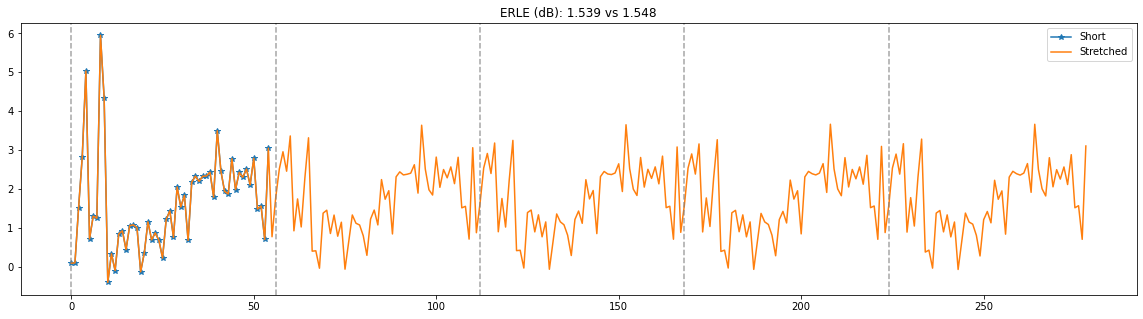

0.008940988096923563

In [7]:
# ERLE graph

win_erle_1 = windowed_calculate_erle(mic, aec_echo_short)
win_erle_2 = windowed_calculate_erle(long_mic, aec_echo_long)

plt.figure(figsize=(20, 5))
plt.plot(win_erle_1, label="Short", marker='*')
plt.plot(win_erle_2, label="Stretched")
plt.legend()

spacing = int(s_len/1024)  # 간격
for xc in range(0, len(win_erle_2), spacing):
    plt.axvline(x=xc, color='gray', linestyle='--', alpha=0.7)
    
plt.title(f"ERLE (dB): {e1:.3f} vs {e2:.3f}")
plt.show()

# Enhancement of ERLE
e2 - e1

- RIR mixing data 는 수렴이 늦음

In [8]:
mic, sr = sf.read("../data/Mixing/RIR_mixed.wav")
ref, sr = sf.read("../data/Mixing/RIR_echo.wav")
gt_ref, sr = sf.read("../data/Mixing/echo.wav")

mic = mic[:, 0]
ref = ref[:, 0]
gt_ref = gt_ref[:]

long_mic = np.concatenate([mic, mic, mic, mic, mic])
long_ref = np.concatenate([ref, ref, ref, ref, ref])
long_gt_ref = np.concatenate([gt_ref, gt_ref, gt_ref, gt_ref, gt_ref])

In [9]:
aec_speech, aec_echo_short = run_AEC(gt_ref, mic, sr, processor=My_MDF)
aec_speech, aec_echo_long = run_AEC(long_gt_ref, long_mic, sr, processor=My_MDF)

s_len = len(mic)
e1 = calculate_erle(ref, aec_echo_short, 'real')
e2 = calculate_erle(long_ref[-s_len:], aec_echo_long[-s_len:], 'real')

print(e1, e2)

1.8355459630917452 15.572952553146385


- RIR Mixing data는 normalization 영향을 많이 받음

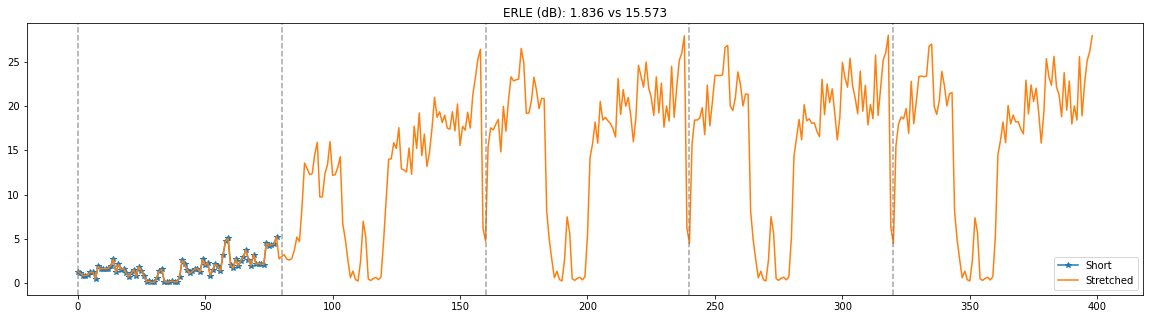

13.73740659005464

In [10]:
# ERLE graph

win_erle_1 = windowed_calculate_erle(mic, aec_echo_short)
win_erle_2 = windowed_calculate_erle(long_mic, aec_echo_long)

plt.figure(figsize=(20, 5))
plt.plot(win_erle_1, label="Short", marker='*')
plt.plot(win_erle_2, label="Stretched")
plt.legend()

spacing = int(s_len/1024)  # 간격
for xc in range(0, len(win_erle_2), spacing):
    plt.axvline(x=xc, color='gray', linestyle='--', alpha=0.7)

plt.title(f"ERLE (dB): {e1:.3f} vs {e2:.3f}")
plt.show()

# Enhancement of ERLE
e2 - e1

# 그럼 그냥 normalization을 해서 넣어주면 어떨까?

In [18]:
temp, sr = sf.read("../data/Vaccum/input.wav")

mic = temp[:, 0]
ref = temp[:, 2]/np.max(temp[:, 2])

long_mic = np.concatenate([mic, mic, mic, mic, mic])
long_ref = np.concatenate([ref, ref, ref, ref, ref])

aec_speech, aec_echo_short = run_AEC(ref, mic, sr, processor=My_MDF)
aec_speech, aec_echo_long = run_AEC(long_ref, long_mic, sr, processor=My_MDF)
#--------------------------------------------------------------------------------
s_len = len(mic)
e1 = calculate_erle(mic, aec_echo_short, 'real')
e2 = calculate_erle(long_mic[:-s_len], aec_echo_long[:-s_len], 'real')

print(e1, e2)

1.5414481198428434 1.5680511224770157


In [16]:
mic, sr = sf.read("../data/Mixing/RIR_mixed.wav")
ref, sr = sf.read("../data/Mixing/RIR_echo.wav")
gt_ref, sr = sf.read("../data/Mixing/echo.wav")

mic = mic[:, 0]
ref = ref[:, 0]
gt_ref = gt_ref/np.max(gt_ref)

long_mic = np.concatenate([mic, mic, mic, mic, mic])
long_ref = np.concatenate([ref, ref, ref, ref, ref])
long_gt_ref = np.concatenate([gt_ref, gt_ref, gt_ref, gt_ref, gt_ref])
#--------------------------------------------------------------------------------
aec_speech, aec_echo_short = run_AEC(gt_ref, mic, sr, processor=My_MDF)
aec_speech, aec_echo_long = run_AEC(long_gt_ref, long_mic, sr, processor=My_MDF)

s_len = len(mic)
e1 = calculate_erle(ref, aec_echo_short, 'simulation')
e2 = calculate_erle(long_ref[-s_len:], aec_echo_long[-s_len:], 'simulation')

print(e1, e2)

13.809843086491494 15.35447253195298


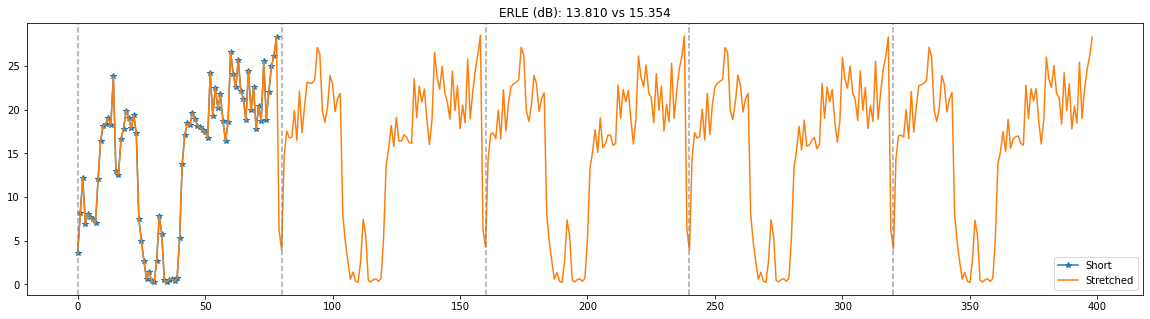

1.5446294454614868

In [17]:
# ERLE graph

win_erle_1 = windowed_calculate_erle(mic, aec_echo_short)
win_erle_2 = windowed_calculate_erle(long_mic, aec_echo_long)

plt.figure(figsize=(20, 5))
plt.plot(win_erle_1, label="Short", marker='*')
plt.plot(win_erle_2, label="Stretched")
plt.legend()

spacing = int(s_len/1024)  # 간격
for xc in range(0, len(win_erle_2), spacing):
    plt.axvline(x=xc, color='gray', linestyle='--', alpha=0.7)

plt.title(f"ERLE (dB): {e1:.3f} vs {e2:.3f}")
plt.show()

# Enhancement of ERLE
e2 - e1

# NEXT:: Converged filter를 Init Filter로 사용해볼까?